In [1]:
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import json
import sys
import import_ipynb
from sklearn.model_selection import train_test_split
import copy
%run ./Data_handling.ipynb
%run ./Data_visualization.ipynb
%run ./Model.ipynb
%run ./Analysis.ipynb

311
304
50


## Data handling

In [2]:
G1 = read_sumo_net1('../Data/s_gyor.net.xml') # type: ignore
#G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"0.00")
#pyg_data = nx_to_pyg(G2)
data_predict = torch.load('../generate/generated_files/data_predict_backup.pth')
data_predict_copy = copy.deepcopy(data_predict)

random_numbers = random.sample(range(len(data_predict)), int(len(data_predict)*0.3))
data_predict_test = [data_predict_copy[i] for i in random_numbers]
data_predict_train = [data_predict_copy[i] for i in range(len(data_predict_copy)) if i not in random_numbers]

with open('../gnn_outputs/edges_to_hide_10_smart.json', 'r') as file:
    edges_to_hide = json.load(file)
prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden = data_preparation_for_forecasting(data_predict_train,data_predict_test, edges_to_hide, True)


In [3]:
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
#data = torch.load('../Data/data.pth')

#edges_to_hide = choose_hidden_edges_well(data, '../Data/s_gyor.net.xml', 3, 7, 0.3, 150)
random.seed(20)
edges_to_hide = list(random.sample(range(504), int(504*0.7)))

#with open('../gnn_outputs/edges_to_hide_10_smart.json', 'r') as file:
#    edges_to_hide = json.load(file)

print(len(edges_to_hide))

352


## Initialization of the model

In [ ]:
data_predict = torch.load('../generate/generated_files/data_predict_backup.pth')
data_predict_copy = copy.deepcopy(data_predict)

random.seed(20)
random_numbers = random.sample(range(len(data_predict)), int(len(data_predict)*0.3))
data_predict_test = [data_predict_copy[i] for i in random_numbers]
data_predict_train = [data_predict_copy[i] for i in range(len(data_predict_copy)) if i not in random_numbers]

with open('../gnn_outputs/edges_to_hide_10_smart.json', 'r') as file:
    edges_to_hide = json.load(file)
prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden = data_preparation_for_forecasting(data_predict_train,data_predict_test, edges_to_hide, True)
number_of_epochs = 5000

# Define the model
edge_dim = 1  # Number of edge features
hidden_dim1 = 32
hidden_dim2 = 64
hidden_dim3 = 64
hidden_dim4 = 32
hidden_dim5 = 32
hidden_dim6 = 32
hidden_dim7 = 32
hidden_dim8 = 32

model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses= training_the_model_forecasting(model, optimizer, criterion, number_of_epochs, prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden, edges_to_hide, 20, time_step=1)

#with open('total_losses.json', 'w') as file:
#    json.dump(total_losses, file)
#with open('losses.json', 'w') as file:
#    json.dump(losses, file)

Epoch 1, Loss: 0.01650485210120678 , Test loss: 0.010771970264613628 


#### Run and Save
By putting the initialization and the training into a function we can, start several model trainings 
this way we donthave to be at our computer to start the next one and manuali save the data we need.
This code will run a training and save the hiden edges, the final model, and the losses.

In [17]:
def run_and_save_forecasting(seed, percent, name, timestep):
    random.seed(seed)
    knownedges = int((1-percent)*500)
    data_predict = torch.load('../generate/generated_files/data_predict_backup.pth')
    data_predict_copy = copy.deepcopy(data_predict)
    edges_to_hide = choose_hidden_edges_well(data, '../Data/s_gyor.net.xml', 3, 7, 0.3, knownedges)
    

    random_numbers = random.sample(range(len(data_predict)), int(len(data_predict)*0.3))
    data_predict_test = [data_predict_copy[i] for i in random_numbers]
    data_predict_train = [data_predict_copy[i] for i in range(len(data_predict_copy)) if i not in random_numbers]
    prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden = data_preparation_for_forecasting(data_predict_train,data_predict_test, edges_to_hide, True)
    number_of_epochs = 4000
    # Define the model
    edge_dim = 1  # Number of edge features
    hidden_dim1 = 32
    hidden_dim2 = 64
    hidden_dim3 = 64
    hidden_dim4 = 32
    hidden_dim5 = 32
    hidden_dim6 = 32
    hidden_dim7 = 32
    hidden_dim8 = 32

    model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses= training_the_model_forecasting(model, optimizer, criterion, number_of_epochs, prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden, edges_to_hide, 20, timestep)
    losses_to_save = [ losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses]
    
    directory = '../forecasting/'
    lossname = directory + 'losses_' + str(percent) +  '_t' + str(timestep)  + '_smart_5_' + str(name) + '.json'
    modelname = directory + 'gnn_model_ces_' + str(percent) +  '_t' + str(timestep) +  '_smart_5_' + str(name) + '.json'
    edgesname = directory + 'edges_to_hide' + str(percent) +  '_t' + str(timestep) + '_smart_5_' + str(name) + '.json'


    with open(lossname, 'w') as file:
        json.dump(losses_to_save, file)

    torch.save(model.state_dict(), modelname)

    with open(edgesname, 'w') as file:
        json.dump(edges_to_hide, file)
    

In [ ]:
def run_and_save(seed, percent, name):
    random.seed(seed)
    #edges_to_hide = list(random.sample(range(504), int(504*percent)))
    knownedges = int((1-percent)*500)
    data = torch.load('../Data/data.pth')
    edges_to_hide = choose_hidden_edges_well(data, '../Data/s_gyor.net.xml', 3, 7, 0.3, knownedges)
    G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
    #with open('../Data/edges_to_hide.json', 'r') as file:
    #    edges_to_hide = json.load(file)
    

    #data_train , data_test = train_test_split(data, test_size=0.3 , shuffle=True)

    data_train = torch.load('../Data/data_train.pth')
    data_test = torch.load('../Data/data_test.pth')

    prepared_training_data, prepared_training_data_hiden, prepared_test_data, prepared_test_data_hiden, summa = data_preparation(data_train, data_test, edges_to_hide, True)
    print(summa)


    # Define the model
    edge_dim = 1  # Number of edge features
    hidden_dim1 = 32
    hidden_dim2 = 64
    hidden_dim3 = 64
    hidden_dim4 = 32
    hidden_dim5 = 32
    hidden_dim6 = 32
    hidden_dim7 = 32
    hidden_dim8 = 32

    model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses= training_the_model(model, optimizer, criterion, 5000, prepared_training_data, prepared_training_data_hiden, prepared_test_data, prepared_test_data_hiden, edges_to_hide, 20)
    losses_30_smart = [ losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses]

    lossname = 'losses_' + str(percent) + '_smart_5_' + str(name) + '.json'
    modelname = 'gnn_model_ces_' + str(percent) + '_smart_5_' + str(name) + '.json'
    edgesname = 'edges_to_hide' + str(percent) + '_smart_5_' + str(name) + '.json'


    with open(lossname, 'w') as file:
        json.dump(losses_30_smart, file)

    torch.save(model.state_dict(), modelname)

    with open(edgesname, 'w') as file:
        json.dump(edges_to_hide, file)

In [19]:
runs_10 =[ [47, 0.9, 'v5',1]
          , [49, 0.7, 'v1',1], [121, 0.7, 'v2',1], [122, 0.7, 'v3',1], [123, 0.7, 'v4',1], [124, 0.7, 'v5',1]
]
for i in runs_10:
    run_and_save_forecasting(i[0],i[1],i[2],i[3])

Epoch 1, Loss: 0.018986864015460014 , Test loss: 0.013306056149303913 
Epoch 21, Loss: 0.0042646764777600765 , Test loss: 0.0031477028969675303 
Epoch 41, Loss: 0.00592970522120595 , Test loss: 0.0054481858387589455 
Epoch 61, Loss: 0.005710219498723745 , Test loss: 0.002560780616477132 
Epoch 81, Loss: 0.0033940072171390057 , Test loss: 0.00620096642524004 
Epoch 101, Loss: 0.005415530409663916 , Test loss: 0.0062586902640759945 
Epoch 121, Loss: 0.0043885051272809505 , Test loss: 0.0035579600371420383 
Epoch 141, Loss: 0.00605586264282465 , Test loss: 0.004974448587745428 
Epoch 161, Loss: 0.005245099309831858 , Test loss: 0.0055151875130832195 
Epoch 181, Loss: 0.0033154429402202368 , Test loss: 0.004907506983727217 
Epoch 201, Loss: 0.003835211740806699 , Test loss: 0.0033842928241938353 
Epoch 221, Loss: 0.003975742496550083 , Test loss: 0.003302354598417878 
Epoch 241, Loss: 0.005786860827356577 , Test loss: 0.002378979232162237 
Epoch 261, Loss: 0.004053337499499321 , Test loss:

In [5]:
torch.save(model.state_dict(), 'gnn_model_ces.pth')
#cep : change every step
layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6, model.conv7, model.conv8]
edge_dims = []
for layer in layers:
    edge_dims.append(layer.in_channels)
edge_dims.append(model.linear.in_features)
with open('dimensions.json','w') as file:
    json.dump(edge_dims, file)


## Loading the model
Once we trained it nd saved it, this is how we can load it

In [ ]:
with open('edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide)

with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('gnn_model_ces.pth'))
output = model2(prepared_training_data[3].edge_attr, prepared_training_data[3].edge_index)



## Data visualization

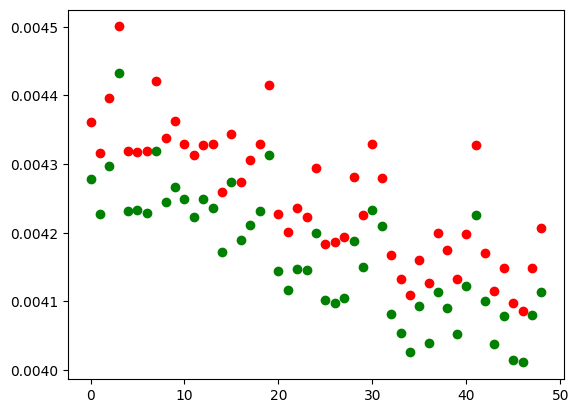

In [25]:
plt.plot(total_train_losses[1:], 'ro', total_test_losses[1:], 'go')
plt.show()

In [151]:
smart30test = total_test_losses
smart30train = total_train_losses

In [102]:
random30test = total_test_losses
random30train = total_train_losses


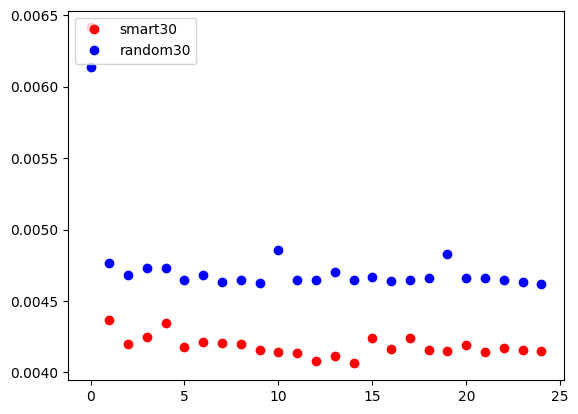

In [152]:
plt.plot(smart30test, 'ro', label = "smart30")
plt.plot(random30test, 'bo', label = "random30")
plt.legend(loc="upper left")
plt.show()

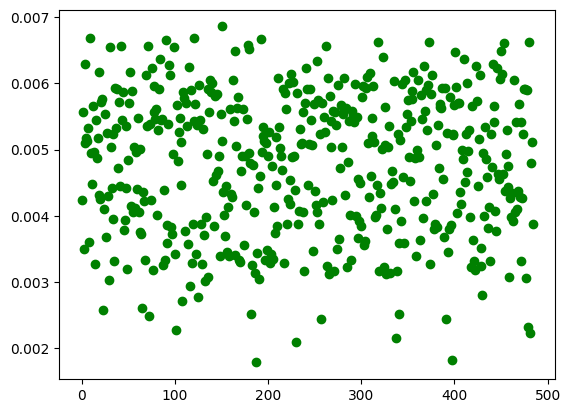

In [164]:
#plt.yscale("log")
plt.plot(losses[15:], 'go')
plt.show()

In [18]:
losses_30_smart = [ losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses]
with open('losses_30_random_5k_v5.json', 'w') as file:
    json.dump(losses_30_smart, file)

In [17]:
torch.save(model.state_dict(), 'gnn_model_ces_30_random_5k_v5.pth')

In [16]:
with open('edges_to_hide_30_ransom.json_5k_v5', 'w') as file:
    json.dump(edges_to_hide, file)

In [146]:
mod = [8, 16, 32, 16, 8, 8, 4, 4]
with open('mod_9.json', 'w') as file:
    json.dump(mod, file)

In [147]:
%run ./Data_visualization.ipynb

In [171]:
with open('../gnn_outputs/edges_to_hide_30_smart.json', 'r') as file:
    edges_to_hide = json.load(file)

In [172]:
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
#with open('../Data/edges_to_hide.json', 'r') as file:
#    edges_to_hide = json.load(file)
data = torch.load('../Data/data.pth')

data_train , data_test = train_test_split(data, test_size=0.3 , shuffle=True)

#data_train = torch.load('../Data/data_train.pth')
#data_test = torch.load('../Data/data_test.pth')

prepared_training_data, prepared_training_data_hiden, prepared_test_data, prepared_test_data_hiden, summa = data_preparation(data_train, data_test, edges_to_hide, True)
print(summa)

tensor(0.0081)


In [173]:

with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('../gnn_outputs/gnn_model_ces_30_smart.pth'))
output = model2(prepared_training_data[3].edge_attr, prepared_training_data[3].edge_index)
